<a href="https://colab.research.google.com/github/maragraziani/interpretAI_DigiPath/blob/main/feature_attribution_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Attribution: Gradient-weighted Class Activation Mapping (Grad-CAM)

This notebook will walk you through the implementation of Grad-CAM visualizations for a 2D Convolutional Neural Network trained on natural images at first (Image-Net pretrained weights) and on a CNN finetuned on histopathology data, namely on the images in the Patch Camelyon dataset. 

In [1]:
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve, auc
import time
import shutil
import numpy as np
import cv2

tf.compat.v1.disable_eager_execution()
tf.keras.backend.clear_session()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_folder='/content/drive/MyDrive/CNNinterpret'

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/CNNinterpret/')
from normalizers import *
# STAIN NORMALIZATION FUNCTIONS
def get_normalizer(patch, save_folder=''):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    print('Normalisers saved to disk.')
    return normalizer

def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))
normalizer=get_normalizer(np.load('/content/drive/MyDrive/CNNinterpret/normalizing_patch.npy'))

Using brightness standardization
Normalisers saved to disk.


In [5]:
import os
import numpy as np

BATCH_SIZE = 32
seed=0
# SET SEED
np.random.seed(seed)
#tf.set_random_seed(seed)

In [6]:
# As a first experiment, we will start with VGG and ImageNet inputs
vgg_model=tf.keras.applications.VGG16(weights='imagenet')

553467904/553467096 [==============================] - 4s 0us/step


In [7]:
# Class Activation Mapping (http://cnnlocalization.csail.mit.edu/)
# Basic Idea:
# Limitation: can only be applied to networks with a GAP layer before the predictions
# Improvement: Grad-CAM (https://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf)
# Grad-CAM is a direct generalization of CAM and does not require the GAP layer
# Basic Idea:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import cv2

def grad_cam(input_model, image, layer_name,H=224,W=224):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    #print (cam)

    cam = np.maximum(cam, 0) # equivalent to RELU pass
    cam = cv2.resize(cam, (H, W))
    #cam = resize(cam, (H, W))
    # cam = zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


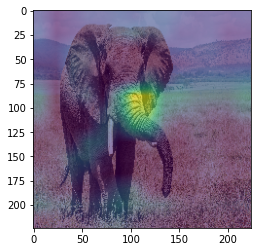

In [8]:
# ELEPHANT
img = image.load_img('/content/drive/MyDrive/CNNinterpret/elephant.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)
hmap=grad_cam(vgg_model, x, 'block5_conv3', H=224, W=224)
# plotting
plt.imshow(img)
plt.imshow(hmap, alpha=0.6)

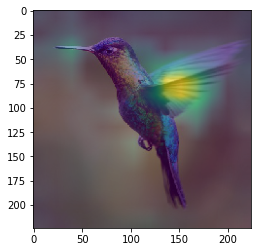

In [9]:
# HUMMINGBIRD
img = image.load_img('/content/drive/MyDrive/CNNinterpret/hummingbird.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)
hmap=grad_cam(vgg_model, x, 'block5_conv3', H=224, W=224)
plt.imshow(img)
plt.imshow(hmap, alpha=0.6)

We now move to the histopathology application. 

We start by loading the data, configuring the data generators and loading the finetuned VGG weights.

In [10]:
# BATCH GENERATORS
import sys
sys.path.append('/content/drive/MyDrive/CNNinterpret/')

def get_batch_data(patch_list, labels, batch_size=32):
    num_samples=len(patch_list)
    while True:
        for offset in range(0,num_samples, batch_size):
            batch_x = []
            batch_y = []
            batch_samples=patch_list[offset:offset+batch_size]
            for patch_id in range(len(batch_samples)):
                #print(len(batch_samples))
                patch=patch_list[patch_id]
                patch=normalize_patch(patch, normalizer)
                # VGG input is fixed to 224,224 for finetuning imagenet weights
                patch=cv2.resize(patch, (224,224)) 
                patch=tf.keras.applications.vgg16.preprocess_input(patch)
                label=labels[patch_id]
                batch_x.append(patch)
                batch_y.append(label)
            
            batch_x=np.asarray(batch_x, dtype=np.float32)/255.
            batch_y=np.asarray(batch_y, dtype=np.float32)
            yield batch_x, batch_y

In [11]:
import h5py as hd
y_test = np.asarray(hd.File('/content/drive/MyDrive/CNNinterpret/camelyonpatch_level_2_split_valid_y.h5', 'r')['y'][:])
x_test = np.asarray(hd.File('/content/drive/MyDrive/CNNinterpret/camelyonpatch_level_2_split_valid_x.h5', 'r')['x'][:])
y_test=y_test[:].ravel()
test_generator = get_batch_data(x_test, y_test)
x_b, y_b = test_generator.__next__()

In [12]:
#Let's load the VGG weights finetuned on the histopathology dataset.
base_model=tf.keras.applications.VGG16(weights='imagenet')
predictions=tf.keras.layers.Dense(1,activation='sigmoid')(base_model.layers[-2].output)
vgg_histo_model = tf.keras.Model(base_model.input, predictions)
vgg_histo_model.load_weights('/content/drive/MyDrive/CNNinterpret/weights.h5')
vgg_histo_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(lr=1e-4), metrics=['accuracy'])

In [13]:
raw_preds=vgg_histo_model.predict(x_b)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'y_true: 1.0, y_pred: [0.90387833]')

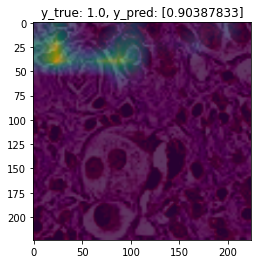

In [14]:
# HISTOPATHOLOGY
idx=24
hmap = grad_cam(vgg_histo_model, np.expand_dims(x_b[idx], 0) , 'block5_conv3', H=224, W=224)
plt.imshow(x_b[idx])
plt.imshow(hmap, alpha=0.6)
plt.title('y_true: {}, y_pred: {}'.format(y_b[idx], raw_preds[idx]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'y_true: 1.0, y_pred: [0.9175341]')

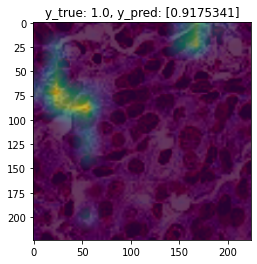

In [15]:
# ANOTHER ONE
idx=9
hmap = grad_cam(vgg_histo_model, np.expand_dims(x_b[idx], 0) , 'block5_conv3', H=224, W=224)
plt.imshow(x_b[idx])
plt.imshow(hmap, alpha=0.6)
plt.title('y_true: {}, y_pred: {}'.format(y_b[idx], raw_preds[idx]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'y_true: 0.0, y_pred: [0.39906508]')

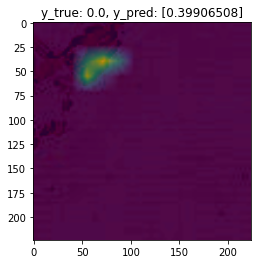

In [16]:
# ANOTHER ONE (NON-TUMOR)
idx=6
hmap = grad_cam(vgg_histo_model, np.expand_dims(x_b[idx], 0) , 'block5_conv3', H=224, W=224)
plt.imshow(x_b[idx])
plt.imshow(hmap, alpha=0.6)
plt.title('y_true: {}, y_pred: {}'.format(y_b[idx], raw_preds[idx]))

In [ ]:
# Other methods: a quick look at the INNvestigate toolbox
# https://github.com/albermax/innvestigate